<a href="https://colab.research.google.com/github/claudiaxpreda/SII/blob/main/SII_Assignment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim 
from gensim.models import Word2Vec
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Input, SpatialDropout1D, concatenate
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, AveragePooling1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import text, sequence


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
WORKDIR = os.getcwd()
FILES_PATH = WORKDIR + '/drive/MyDrive/SII/SII-Challenge/'


In [ ]:
DEV_NAME = 'referate-dev.json'
TRAIN_NAME = 'referate-train.json'
TEST_DEV = 'referate-test.json'

def get_frame(name):
  return pd.read_json(FILES_PATH + name)


In [ ]:
train = get_frame(TRAIN_NAME)
dev = get_frame(DEV_NAME)
test = get_frame(TEST_DEV)

def print_size(name, frame):
  format = 'The size of {} set is: {}'
  print(format.format(name, len(frame)))

**Data Analyze**

In [ ]:
print_size('train', train)
print_size('dev', dev)
print_size('test', test)

The size of train set is: 4725
The size of dev set is: 500
The size of test set is: 500


In [ ]:
train.info()

In [ ]:
stopwords = []

with open('/content/drive/MyDrive/SII/SII-Challenge/romanian_stopwords.txt', 'r') as f: 
    for line in f:
        stopwords.append(line.strip())

print(stopwords)

['vreo', 'acelea', 'cata', 'cita', 'degraba', 'lor', 'alta', 'tot', 'ai', 'dat', 'despre', 'peste', 'bine', 'dar', 'foarte', 'avea', 'multi', 'cit', 'cat', 'alt', 'mai', 'sa', 'fie', 'tu', 'intrucat', 'multe', 'orice', 'dintr', 'dintre', 'dintr-o', 'dintr-un', 'se', 'intr', 'intr-o', 'intr-un', 'niste', 'multa', 'insa', 'il', 'fost', 'a', 'abia', 'nimic', 'sub', 'acel', 'in', 'altceva', 'si', 'avem', 'altfel', 'c', 'ea', 'acest', 'li', 'parca', 'fi', 'dintre', 'unele', 'm', 'acestei', 'mare', 'cel', 'este', 'pe', 'atitia', 'atatia', 'uneori', 'acela', 'iti', 'astazi', 'acestui', 'o', 'imi', 'ele', 'ceilalti', 'pai', 'fata', 'noua', 'sa-ti', 'altul', 'au', 'i', 'prin', 'conform', 'aceste', 'anume', 'azi', 'k', 'unul', 'ala', 'unei', 'fara', 'ei', 'la', 'aceeasi', 'u', 'inapoi', 'acestea', 'acesta', 'aceasta', 'catre', 'sale', 'asupra', 'as', 'aceea', 'ba', 'ale', 'da', 'le', 'apoi', 'aia', 'suntem', 'cum', 'isi', 'inainte', 's', 'de', 'cind', 'cand', 'cumva', 'chiar', 'acestia', 'daca',

In [ ]:
train.isnull().sum()

In [ ]:
train.head(5)

In [ ]:
train_categories = train.category.unique()
test_categories = test.category.unique()

print(train_categories)

In [ ]:
no_text = train[train['text'].str.len() == 0]
no_text

**Data pre-processing**

In [ ]:
train['processed_text'] = train['text'].apply(lambda x: x.lower())
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul si tatuajele - vanitati adolescent...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate ale semiramidei a doua mi...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (1880-1961) \nmihail sadovea...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu \ns-a nascut pe 15 ianuarie 1850 la ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara cu noroc ioan slavici \ncaracterizarea l...


In [ ]:
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in stopwords])

train['processed_text'] = train['processed_text'].apply(lambda x: remove_stopwords(x))

train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul tatuajele - vanitati adolescentine...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate semiramidei doua minune l...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (1880-1961) mihail sadoveanu ...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu s-a nascut 15 ianuarie 1850 botosani ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara ioan slavici caracterizarea ghita ghita ...


In [ ]:
train.processed_text.iloc[2]

In [ ]:
import re

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    x = re.sub('[0-9]', '#', x)

    return x

train['processed_text'] = train['processed_text'].apply(lambda x : clean_numbers(x))
train.head(5)

,index,filename,text,category,grade,processed_text
0,3685,Referat Piercing-ul si adolescentii,Piercing-ul si tatuajele - vanitati adolescent...,psihologie,5.65,piercing-ul tatuajele - vanitati adolescentine...
1,775,Gradinile Suspendate Ale Semiramidei,GRADINILE SUSPENDATE ALE SEMIRAMIDEI A doua mi...,istorie,9.00,gradinile suspendate semiramidei doua minune l...
2,1765,Referat Mihail Sadoveanu,MIHAIL SADOVEANU (1880-1961) \nMihail Sadovea...,romana,5.36,mihail sadoveanu (####-####) mihail sadoveanu ...
3,3691,Referat Eminescu,EMINESCU \nS-a nascut pe 15 ianuarie 1850 la ...,romana,5.35,eminescu s-a nascut ## ianuarie #### botosani ...
4,3402,Moara,Moara cu noroc Ioan Slavici \nCaracterizarea l...,romana,10.00,moara ioan slavici caracterizarea ghita ghita ...


In [ ]:
train.processed_text.iloc[100]

In [ ]:
train['processed_text'] = train['processed_text'].apply(lambda x : re.sub(r'[^\x00-\x7F]+',' ', x))

In [ ]:
dev['processed_text'] = dev['text'].apply(lambda x: x.lower())
dev['processed_text'] = dev['processed_text'].apply(lambda x : remove_stopwords(x))
dev['processed_text'] = dev['processed_text'].apply(lambda x : re.sub(r'[^\x00-\x7F]+',' ', x))
dev['processed_text'] = dev['processed_text'].apply(lambda x : clean_numbers(x))

dev.processed_text.iloc[3]

In [ ]:
test['processed_text'] = test['text'].apply(lambda x: x.lower())
test['processed_text'] = test['processed_text'].apply(lambda x : remove_stopwords(x))
test['processed_text'] = test['processed_text'].apply(lambda x : re.sub(r'[^\x00-\x7F]+',' ', x))
test['processed_text'] = test['processed_text'].apply(lambda x : clean_numbers(x))

**Embeddings**

In [ ]:
# from gensim.models.phrases import Phrases, Phraser
# from collections import defaultdict

# sent = [row.split() for row in train['processed_text']]

# phrases = Phrases(sent, min_count=30, progress_per=10000)

# bigram = Phraser(phrases)
# sentences = bigram[sent]

# word_freq = defaultdict(int)
# for sent in sentences:
#     for i in sent:
#         word_freq[i] += 1
# len(word_freq)

In [ ]:
# sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [ ]:
# import multiprocessing

# from gensim.models import Word2Vec

# w2v_model = Word2Vec(min_count=20,
#                      window=2,
#                      size=300,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20)

In [ ]:
# w2v_model.build_vocab(sentences, progress_per=10000)

In [ ]:
# w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

(15562229, 25854195)

In [ ]:
# w2v_model.wv.save_word2vec_format('/content/drive/MyDrive/SII/embedding2.bin', binary=True)

In [ ]:
# w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.most_similar(positive=["scrisoare"])

[('scrisoare_pierduta', 0.4295188784599304),
 ('pierderea_scrisori', 0.4179714322090149),
 ('scrisoare.', 0.4065089821815491),
 ('pierduta”', 0.3701888918876648),
 ('poliţă', 0.35345524549484253),
 ('pierdută', 0.3490915596485138),
 ('telegrama', 0.3445854187011719),
 ('cerandu-i', 0.33844509720802307),
 ('d-ale', 0.33758920431137085),
 ('scrisori', 0.33727163076400757)]

**Models**

9223.244867724869 18263.820990675613 444535


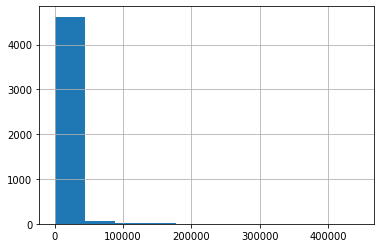

In [ ]:
lens = train.processed_text.str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist()

In [ ]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
sentences = train["processed_text"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 4725/4725 [00:01<00:00, 2778.06it/s]

{'piercing-ul': 3, 'tatuajele': 2, '-': 30657, 'vanitati': 2, 'adolescentine?': 1}


In [ ]:
from gensim.models import KeyedVectors
embeddings_index = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/SII/SII-Challenge/model.bin', binary=True)

In [ ]:
embeddings_index_2 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/SII/SII-Challenge/embedding2.bin', binary=True)

In [ ]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [ ]:
oov = check_coverage(vocab,embeddings_index)

100%|██████████| 555040/555040 [00:01<00:00, 399433.81it/s]

Found embeddings for 36.03% of vocab
Found embeddings for  76.50% of all text


In [ ]:
embeddings_index.similar_by_word("comentariu")

[('veziadaugă', 0.751944363117218),
 ('votscrie', 0.7479938268661499),
 ('.sobru', 0.7449974417686462),
 ('momentanscrieti', 0.7340505123138428),
 ('filcu', 0.7320773601531982),
 ('vechilasă', 0.7216393351554871),
 ('0)hits', 0.7141861319541931),
 ('var3', 0.7130448818206787),
 ('startanterior12345678910următorend', 0.7109917402267456),
 ('0raspundeiulia', 0.7098747491836548)]

In [ ]:
all_embs = np.stack(embeddings_index.vectors)

emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    try:
      embedding_vector = embeddings_index[word]
      if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    except:
      pass

print(embed_size)

100


**Prepare input**

In [ ]:
embed_size = 100
maxlen = 18000

train_X = tokenizer.texts_to_sequences(train['processed_text'])
val_X = tokenizer.texts_to_sequences(dev['processed_text'])
test_X = tokenizer.texts_to_sequences(test['processed_text'])

train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
Y_train = train['grade'].values
Y_val = dev['grade'].values

**Define the models**

In [ ]:
def get_model_1():
  model = Sequential()
  # model.add(Embedding(max_features, embed_size))
  model.add(Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False))
  model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2,return_sequences=True))
  model.add(LSTM(units = 64, dropout = 0.2, recurrent_dropout = 0.2))
  model.add(Dropout(0.1))
  model.add(Dense(units = 1, activation = 'relu'))
  
  return model
    

def get_model_2():
  inp = Input(shape=(maxlen, ))
  x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable = False)(inp)
  x = GlobalMaxPooling1D()(x)
  x = Dropout(0.25)(x)
  x = Dense(50, activation="relu")(x)
  x = Dropout(0.25)(x)
  x = Dense(1, activation="relu")(x)
  model = Model(inp,x)
  return model

def compile_model(model):
  model.compile(loss=tf.keras.losses.MeanSquaredError(name="loss_mse")
, optimizer='adam', metrics=tf.keras.losses.MeanSquaredError(name="mse"))

print(get_model_2().summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 18000)]           0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 18000, 100)        3000000   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 100)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51  

**Train the second model**

In [ ]:
model3 = get_model_2()
compile_model(model3)
batch_size = 64
epochs = 10


early = EarlyStopping(monitor="val_loss_mse", mode="min", patience=5)
callbacks_list = [early]

with tf.device('/device:GPU:0'):
  history = model3.fit(train_X, Y_train, validation_data=(val_X, Y_val), batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

**Predict**

In [ ]:
y_test = model1.predict(test_X)

In [ ]:
print(y_test.shape)

**Check result file**

In [ ]:
trial = pd.read_json('/content/drive/MyDrive/SII/SII-Challenge/test_results-embd.json')
trial.tail()

,index,filename,text,category,grades
495,3591,Morometi,Morometii \n-Personaje principale \n -Parin...,romana,6.347172
496,5389,Padurea Spanzuratilor - Comentariu,Padurea spanzuratilor de Liviu Rebreanu \nTema...,romana,7.315770
497,1496,Referat Marsul lui Radetzky,MARELE ZID CHINEZESC \n Constructie gi...,istorie,6.059397
498,911,Referat Ciresarii - Cavalerii florii de cires,A Z U G A Valea Prahovei a ...,romana,8.547588
499,5266,Constitutia,ISTORIA CONSTITUŢIONALĂ A ROMÂNIEI \nParcurger...,istorie,8.459164
